# Association testing (GWAS)

In [1]:
%load_ext lab_black
import matplotlib.pyplot as plt
import admix
import numpy as np

np.random.seed(1234)

In [2]:
dset = admix.io.read_dataset("example_data/CEU-YRI")

In [3]:
dset

admix.Dataset object with n_snp x n_indiv = 15357 x 10000, n_anc=2
	snp: 'CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO'

In [4]:
af_per_anc = dset.af_per_anc()  # calculate allele frequency by ancestry
snp_list = dset.snp.index[np.all((0.01 < af_per_anc) & (af_per_anc < 0.99), axis=1)][
    0:1000
]
dset = dset[snp_list, :]  # filter by allele frequency between 1%-99%.

# simulate binary phenotypes
sim = admix.simulate.quant_pheno(dset, n_causal=2, hsq=0.01, cor=1.0)
beta, pheno_g, pheno = sim["beta"], sim["pheno_g"], sim["pheno"]
print(beta.shape)  # (n_snp, n_anc, n_sim)
print(pheno_g.shape)  # (n_indiv, n_sim)
print(pheno.shape)  # (n_indiv, n_sim)

admix.simulate.quant_pheno: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.72it/s]

(1000, 2, 10)
(10000, 10)
(10000, 10)


In [5]:
dset

admix.Dataset object with n_snp x n_indiv = 1000 x 10000, n_anc=2
	snp: 'CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO'

In [6]:
sim_i = 0
sim_pheno = pheno[:, sim_i]
sim_beta = beta[:, :, sim_i]
assoc_df = admix.assoc.marginal(
    dset=dset,
    pheno=sim_pheno,
    method="ATT",
    family="linear",
)

admix.assoc.marginal: 100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.32it/s]


In [7]:
assoc_df

,G_BETA,G_SE,N,P
snp,,,,
22:16406147:A:G,-0.020341,0.028045,10000,4.682764e-01
22:16551808:T:C,-0.015835,0.014218,10000,2.654258e-01
22:16573830:T:C,-0.019458,0.030027,10000,5.169898e-01
22:16575525:T:C,-0.005990,0.014806,10000,6.857933e-01
22:16576248:G:T,-0.017495,0.017168,10000,3.081942e-01
...,...,...,...,...
22:19743069:G:A,0.092459,0.016553,10000,2.388196e-08
22:19746288:G:A,-0.019776,0.019905,10000,3.204777e-01
22:19748331:T:C,-0.022343,0.014272,10000,1.174854e-01


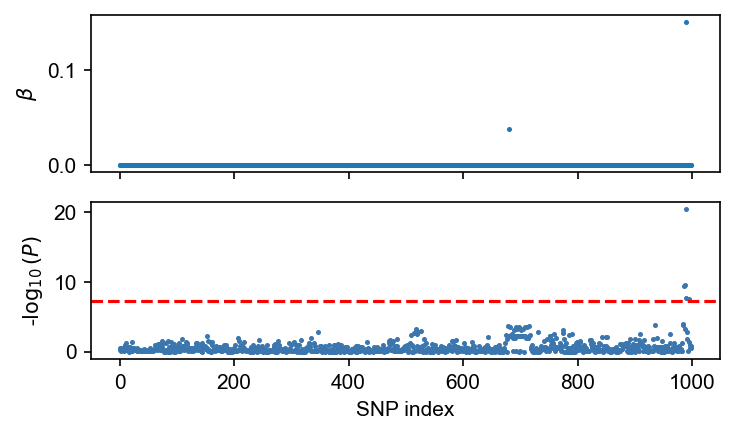

In [8]:
fig, axes = plt.subplots(nrows=2, figsize=(5, 3), dpi=150, sharex=True)
axes[0].scatter(np.arange(dset.n_snp), sim_beta[:, 0], s=2)
axes[0].set_ylabel(r"$\beta$")

admix.plot.manhattan(assoc_df.P, ax=axes[1], s=2)
plt.tight_layout()
plt.show()

In [9]:
# pick one simulation
pval_dict = dict()
for method in ["TRACTOR", "ATT", "ASE"]:
    pval_dict[method] = admix.assoc.marginal(
        dset=dset,
        pheno=sim_pheno,
        family="linear",
        method=method,
    ).P

admix.assoc.marginal: 100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.50s/it]


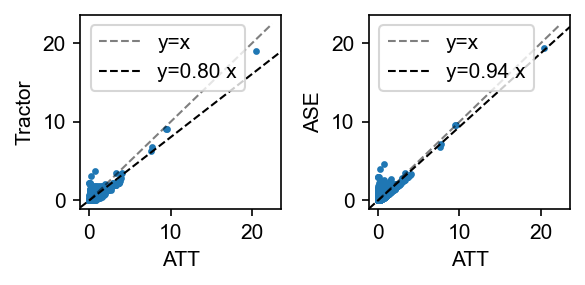

In [10]:
fig, axes = plt.subplots(figsize=(4, 2), dpi=150, ncols=2)
admix.plot.compare_pval(
    pval_dict["ATT"], pval_dict["TRACTOR"], xlabel="ATT", ylabel="Tractor", ax=axes[0]
)
admix.plot.compare_pval(
    pval_dict["ATT"], pval_dict["ASE"], xlabel="ATT", ylabel="ASE", ax=axes[1]
)
fig.tight_layout()

## HET test

HET tests the null hypothesis for coefficients for a set of variables are identical. In the case of two-way admixed populations. It tests the null of 
$H_0: \beta_{s,1} = \beta_{s,2}$ for each SNP $s$.

In the following, although we simulate phenotype with no heterogeneity by ancestry, we still get an inflated p-value distribution. This is because the LD induce partial heterogeneity in the effect sizes.

Currently HET test is not implemented with cpp so one can expect slower performance. It is recommended to perform HET test in a small subset of variants after LD clumping.

```bash
# <out>.clumped will be created
plink \
    --bfile <bfile> \
    --clump <out>.assoc \
    --clump-p1 5e-8 \
    --clump-p2 1e-4 \
    --clump-r2 0.1 \
    --clump-kb 10000 \
    --memory 20000 \
    --out <out>

# get list of clumped SNPs
awk '(NF > 0) && (NR > 1) {print $3 }' <out>.clumped > <out>.clumped.snp_list
```

In [11]:
het_df = admix.assoc.marginal(
    dset=dset,
    pheno=sim_pheno,
    family="linear",
    method="HET",
)

admix.assoc.marginal:   0%|                                                                                          | 0/2 [00:00<?, ?it/s]

2024-01-27 20:05:42 [info     ] Currently HET test is implemented through statsmodels, which can be slow. Pass in small amount of data whenever possible.


admix.assoc.marginal:  50%|█████████████████████████████████████████                                         | 1/2 [00:04<00:04,  4.67s/it]

2024-01-27 20:05:47 [info     ] Currently HET test is implemented through statsmodels, which can be slow. Pass in small amount of data whenever possible.


admix.assoc.marginal: 100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.11s/it]


lambda GC: 2.22 [1.85, 2.54]


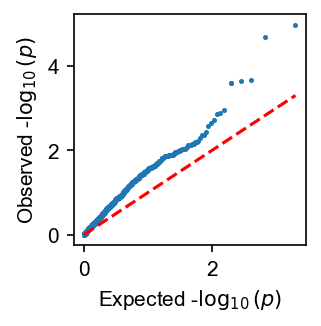

In [12]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
admix.plot.qq(het_df.P.values, bootstrap_ci=True, ax=ax)
plt.show()